# UV-Guider alignement with source in autocoll
##  Field 3

In [1]:
cd ../..

/home/jovyan


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from Calibration.mapping import Mapping

## initialization from last xy calib

In [3]:
G2UV = Guider2UV(filename='Notebook/2018/data_needed_to_run_notebooks/F3_180826_2.pkl')
print(G2UV)

FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>): (lon, lat) in deg
    [(0.17979887, -0.02325374)]>
FOV center pixel position in guider [array([1347.26210746]), array([450.73438835])]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (352.3424, 0.21245)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 44.2677914054

In [4]:
target_filename = 'Calibration/Targets/targets_F3.txt'
F3 = Table.read(target_filename, format='ascii')

## Diffuse UV image

load new mapping

In [5]:
mask_det_map_file = 'Notebook/2018/data_needed_to_run_notebooks/mapping-mask-det-180612-F3.pkl'
mask_det_map = Mapping(mask_det_map_file)
G2UV.set_detector_mapping(mask_det_map, offsets = [1., 1.])


## Scan sequence

gc - 41 - 42 - 32 - 30 - 9 - 4 - 10 - 13

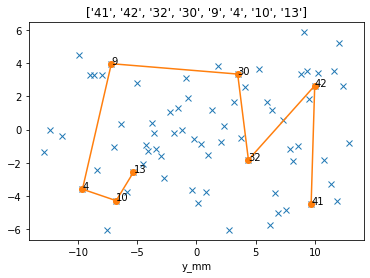

Internal-count,xmm,ymm,RA,DEC,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
41,9.692238,-4.486605,352.570099,0.107245,-25.487955350622904,-601.1640000000001,601.7040724176258
42,9.994533,2.641369,352.577179,0.274235,474.38456618061485,375.28920000000005,604.8823854825087
32,4.391899,-1.817091,352.445404,0.169988,76.68326250800965,-434.61,441.32320905303897
30,3.484085,3.340942,352.424103,0.290713,902.076388144646,-53.4528000000001,903.6586810715261
9,-7.189261,3.964764,352.173523,0.305561,206.97905658075254,638.5536000000001,671.2607764021509
4,-9.632198,-3.583395,352.116028,0.128185,-241.2569962183421,57.85919999999996,248.0980154070909
10,-6.784192,-4.273481,352.183044,0.112113,-123.26736401443851,-143.73000000000002,189.34929609340537
13,-5.32832,-2.571499,352.217285,0.152038,0.0,0.0,0.0
13,-5.32832,-2.571499,352.217285,0.152038,123.26716601203117,143.73000000000002,189.34916719288114


In [6]:
#from guider2UV.guider2UV import Guider2UV
slits = ['41', '42', '32', '30', '9', '4', '10', '13'] 
F1=F3
F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

ra,dec = "RA", "DEC"
x,y = "xmm","ymm"
plt.figure()
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title(slits)
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = vstack((selected_slits,selected_slits[::-1]) )
# slit_path["ra_diff"] = [0] + list((slit_path[ra][1:] - slit_path[ra][:-1])*np.cos(slit_path[dec][:-1]*np.pi/180)) 
# slit_path["dec_diff"] = [0] + list((slit_path[dec][1:] - slit_path[dec][:-1])) 
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

In [7]:



movs, flags, slits_coord = G2UV.compute_autocoll_moves_slits(slits, F3, hystcomp = True)

slit position in mm on mask: [ 9.692238 -4.486605]
slit position in mm on mask: [9.994533 2.641369]
slit position in mm on mask: [ 4.391899 -1.817091]
slit position in mm on mask: [3.484085 3.340942]
slit position in mm on mask: [-7.189261  3.964764]
slit position in mm on mask: [-9.632198 -3.583395]
slit position in mm on mask: [-6.784192 -4.273481]
slit position in mm on mask: [-5.32832  -2.571499]

targets local coords in siderostat local frame:
EL: 137.0 arcsec ; CE: 444.8 arcsec
EL: 440.1 arcsec ; CE: 453.5 arcsec
EL: 247.7 arcsec ; CE: 223.4 arcsec
EL: 466.1 arcsec ; CE: 183.1 arcsec
EL: 486.9 arcsec ; CE: -259.2 arcsec
EL: 164.9 arcsec ; CE: -356.6 arcsec
EL: 137.2 arcsec ; CE: -238.1 arcsec
EL: 210.3 arcsec ; CE: -178.6 arcsec

siderostat moves sequence: 


observed slits position :

In [8]:
slits_coord_obs_det = np.array([
       [1988.41878403,  106.44539382],
       [1508.6230669 ,   94.16400114],
       [1822.7014584 ,  516.16028525],
       [1477.52007584,  593.68117987],
       [1447.92426796, 1411.47702315],
       [1956.33276732, 1590.47665766],
       [2001.79997879, 1373.67216511],
       [1887.22774603, 1265.54090648],
# retour
       [1887.38268588, 1260.91895482],
       [2001.62796297, 1368.91605632],
       [1956.14587627, 1594.1909615 ],
       [1448.1237799 , 1417.47802767],
       [1477.68955404,  598.70432329],
       [1822.91909465,  521.68723695],
       [1508.25355969,   90.13554281],
       [1987.94755047,  102.14549882]])

slits_coord_obs_det

array([[1988.41878403,  106.44539382],
       [1508.6230669 ,   94.16400114],
       [1822.7014584 ,  516.16028525],
       [1477.52007584,  593.68117987],
       [1447.92426796, 1411.47702315],
       [1956.33276732, 1590.47665766],
       [2001.79997879, 1373.67216511],
       [1887.22774603, 1265.54090648],
       [1887.38268588, 1260.91895482],
       [2001.62796297, 1368.91605632],
       [1956.14587627, 1594.1909615 ],
       [1448.1237799 , 1417.47802767],
       [1477.68955404,  598.70432329],
       [1822.91909465,  521.68723695],
       [1508.25355969,   90.13554281],
       [1987.94755047,  102.14549882]])

In [9]:
valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave = G2UV.mask_det_map.w[0]
print("wave: ", obs_wave)

slits_coord_valid = [slits_coord[i] for i in np.nonzero(valid)[0]]
slits_valid = np.array(slits + slits[::-1])[valid]

wave:  0.20255


In [10]:
# mid  = len(slits_coord_obs_det)//2
# pair_diff = slits_coord_obs_det[:mid] - slits_coord_obs_det[::-1][:mid]
# pair_diff
# plt.figure()
# plt.subplot('120')
# plt.plot(pair_diff[:,0],'*')
# plt.plot(np.abs(pair_diff[:,0]),'-')
# plt.title("El pair diff")
# plt.ylabel("El arcsec")
# plt.subplot('121')
# plt.plot(pair_diff[:,1],'*')
# plt.plot(np.abs(pair_diff[:,1]),'-')
# plt.title("Ce pair diff")
# plt.ylabel("Ce arcsec")


In [11]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )


Fitting rotation, translation and magnification
gamma: 0.9989454166629014
theta: -40.67468466107563 arcmin
dx: 14.671103346670067 arcsec
dy: 1.362047476404868 arcsec
variances: [3.73391028e-04 1.24378885e+00 3.30334925e-01 3.35781647e-01]

residuals in arcsec: [[ 0.33867091  0.63039789]
 [ 0.47797165  0.93185503]
 [-0.45555051 -0.87219076]
 [-1.46529235 -1.03970432]
 [ 0.35919206 -3.93731662]
 [ 1.31949616 -2.01008753]
 [-0.35022796  1.65963514]
 [-0.47285333  3.18485562]
 [-0.61137007 -1.95202791]
 [-0.0567475  -3.59530069]
 [ 1.48012079  2.12832775]
 [ 0.03841903  2.75226543]
 [-1.65891016  4.53827491]
 [-0.70185714  5.2720234 ]
 [ 0.88473358 -3.55884668]
 [ 0.87420483 -4.13216066]]
max residual in EL,CE 1.7, 5.3 arcsec
mean residual in EL,CE 0.9, 3.0 arcsec


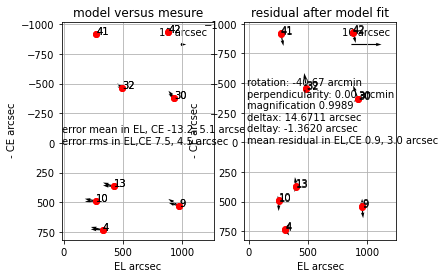

After updating:
    mask_rotation: 3.593106744344084 arcmin
    FOV center in guider: [1361.01487994] x [444.15399857] pix = [660.27394964] arcsec x [-89.92157142] arcsec arcsec
    mask_magnification correction: 0.9989454166629014  
    


In [12]:
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)

G2UVcor,residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, labels=slits_valid, plot=True, weight=weight)

In [13]:
#G2UVcor.save(filename=cloudpath + 'TestsFTS2018-Flight/E2E-AIT-Flight/XYCalibration/F3_180904.pkl')

In [14]:
movs_new, flags, slits_coord_new = G2UVcor.compute_autocoll_moves_slits(slits, F3, hystcomp = True)

slit position in mm on mask: [ 9.692238 -4.486605]
slit position in mm on mask: [9.994533 2.641369]
slit position in mm on mask: [ 4.391899 -1.817091]
slit position in mm on mask: [3.484085 3.340942]
slit position in mm on mask: [-7.189261  3.964764]
slit position in mm on mask: [-9.632198 -3.583395]
slit position in mm on mask: [-6.784192 -4.273481]
slit position in mm on mask: [-5.32832  -2.571499]

targets local coords in siderostat local frame:
EL: 138.8 arcsec ; CE: 445.2 arcsec
EL: 441.5 arcsec ; CE: 457.4 arcsec
EL: 252.0 arcsec ; CE: 225.4 arcsec
EL: 470.7 arcsec ; CE: 187.6 arcsec
EL: 496.8 arcsec ; CE: -254.0 arcsec
EL: 176.3 arcsec ; CE: -355.0 arcsec
EL: 147.3 arcsec ; CE: -236.8 arcsec
EL: 219.6 arcsec ; CE: -176.6 arcsec

siderostat moves sequence: 


In [15]:
CEg, Elg = 1.02928, 1.00379
from astropy.table import hstack
moves=movs_new
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))


moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]
moves["UV_image"] = moves["UV_image"].astype(bool)
new_cat = hstack((slit_path,moves[moves["UV_image"]][1:-1]))
new_cat
new_cat["EL_moves"] =  list(new_cat["EL_abs"][1:] - new_cat["EL_abs"][:-1]) +  [0]
new_cat["CE_moves"] =  list(new_cat["CE_abs"][1:] - new_cat["CE_abs"][:-1]) +  [0]



new_cat["El_sky"] = new_cat["EL_moves"]  * 2 * Elg 
new_cat["Cel_sky"] = new_cat["CE_moves"] * 2 * CEg 
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
new_cat.to_pandas().to_clipboard()
new_cat["ra_diff","dec_diff","EL_moves","CE_moves","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]


/tmp/ipykernel_465/799231450.py:20: RuntimeWarning: invalid value encountered in divide
  new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
/tmp/ipykernel_465/799231450.py:21: RuntimeWarning: invalid value encountered in divide
  new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
/tmp/ipykernel_465/799231450.py:22: RuntimeWarning: invalid value encountered in divide
  new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]


PyperclipException: 
    Pyperclip could not find a copy/paste mechanism for your system.
    For more information, please visit
    https://pyperclip.readthedocs.io/en/latest/#not-implemented-error
    

## Star sequence

gc - s20 - s5 - s9 

In [17]:
star_target_path = cloudpath + 'Target_selection/GuidingStars/'
F3_stars = Table.read(star_target_path + "F3_guidingstars.fits", format='fits')

stars = [20, 5, 9]


star_movs, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F3_stars, hystcomp = True)


star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(352.387774, -0.111235)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(352.228576, -0.041124)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(352.267202, 0.107397)]>

targets local coords in siderostat local frame:
EL: -251.5 arcsec ; CE: 123.6 arcsec
EL: -126.0 arcsec ; CE: -154.9 arcsec
EL: 140.4 arcsec ; CE: -87.6 arcsec

siderostat moves sequence: 
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: False
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: True
EL: -251.5 arcsec ; CE 123.6 arcsec ; image: True
EL: 125.4 arcsec ; CE -278.5 arcsec ; image: True
EL: 266.4 arcsec ; CE 67.3 arcsec ; image: True
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: False
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: True
EL: -266.4 arcsec ; CE -97.3 arcsec ; image: False
EL: 0.0 arcsec ; CE 30.0 arcsec ; image: True
EL: -125.4 arcsec ; CE 308.5 arcsec ; image: False
EL: -0.0 arcsec ; CE -30.0 arcsec ; image: True
EL: 251.5 a

In [18]:
stars_coord

[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(-0.14022818, -0.07069044)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(-0.07028362, 0.08858072)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.07827793, 0.05010985)]>]

------------------------------------------------------

# Quasar stars

In [23]:
from guider2UV.MaskAstrometry import LocalScienceMaskProjector

G2UV_QSO = G2UVcor.copy()

Field_center = coordinates.SkyCoord(270.52256162*u.deg, 44.0392496*u.deg)
Field_rotation = 110.09593332038546*u.deg
Field_gamma = G2UVcor.FieldP.gamma

FieldP_QSO = LocalScienceMaskProjector(Field_center, Field_rotation, Field_gamma)

G2UV_QSO.FieldP = FieldP_QSO

In [24]:
print(G2UV_QSO)


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=20.095933320385456 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (270.52256162, 44.0392496)>)>
    gamma: 0.9989454166629014

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 3.593106744344041 arcmin
    FOV center in guider: [1361.01487994]x[444.15399857] pix



In [41]:
star_target_path = cloudpath + 'Target_selection/GuidingStars/'

#Table.read(star_target_path + "F3_guidingstars.fits", format='fits')

QSO_stars_radec = np.array([[270.238893, 44.214653], # Mag 8.5
                        [270.215559,44.119755]]) # Mag 8.7

QSO_stars_table = Table(QSO_stars_radec, names=[ 'RA', 'DEC'])
QSO_stars_table['Internal count'] = [1,2]

stars = [1,2]
star_movs, stars_coord = G2UV_QSO.compute_autocoll_move_stars(stars, QSO_stars_table, hystcomp = True)


star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(270.238893, 44.214653)]>
star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(270.215559, 44.119755)]>

targets local coords in siderostat local frame:
EL: -122.0 arcsec ; CE: -122.3 arcsec
EL: -92.1 arcsec ; CE: 43.6 arcsec

siderostat moves sequence: 
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: False
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: True
EL: -122.0 arcsec ; CE -122.3 arcsec ; image: True
EL: 29.9 arcsec ; CE 166.0 arcsec ; image: True
EL: -0.0 arcsec ; CE 30.0 arcsec ; image: False
EL: 0.0 arcsec ; CE -30.0 arcsec ; image: True
EL: -29.9 arcsec ; CE -196.0 arcsec ; image: False
EL: 0.0 arcsec ; CE 30.0 arcsec ; image: True
EL: 122.0 arcsec ; CE 122.3 arcsec ; image: True


In [43]:
stars_radec_coord = coordinates.SkyCoord(QSO_stars_radec[:,0]*u.deg, QSO_stars_radec[:,1]*u.deg)

QSO_stars_pos_guider_pix = G2UV_QSO.SienceMask2guider(stars_radec_coord, world=True, angle=False)
print(QSO_stars_pos_guider_pix)

[array([360.97637173, 430.05207998]), array([828.83300343, 437.60340627])]


In [37]:
#star_target_path = cloudpath + 'Target_selection/GuidingStars/'

#Table.read(star_target_path + "F3_guidingstars.fits", format='fits')

from astropy.table import Column
QSO_stars_radec = np.array([[270.238893, 44.214653], # Mag 8.5
                        [270.215559,44.119755]]) # Mag 8.7

QSO_stars_table = Table(QSO_stars_radec, names=[ 'RA', 'DEC'])
QSO_stars_table['Internal count'] = [1,2]

In [38]:
QSO_stars_table

RA,DEC,Internal count
float64,float64,int64
270.238893,44.214653,1
270.215559,44.119755,2
